
# Predicting Player RAR Through Age 30

This project serves as a quick dive into player value prediction through a player's age 30 season. This is a very basic and quick exploration of these topics. There are many more in-depth and intesive avenues that this concept can and has been pursued. The data sets are sourced from http://www.seanlahman.com/baseball-archive/statistics/ which contain basic offensive stats as well as counts of defensive starts. Many assumptions and simplifications of key metrics are made for the sake of simplification as this is moreso a proof-of-concept rather than an actionable report.

In [1]:
# Everyone's favorite standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Reading in the .csv data
batting = pd.read_csv("Batting.csv")
people = pd.read_csv("People.csv")
appearances = pd.read_csv("Appearances.csv")
prospects = pd.read_excel('historic_prospect_ranking_with_Lahman_ID.xlsx')

## Data Prep & Cleaning
Now that we have the three main data sets loaded in, we can make the initial trimmings as we are only considering play from 1994 to 2017.

In [3]:
cut_off_year = 1994 # Creating a cutoff year as the game is drastically different over time
batting = batting[batting.yearID >= cut_off_year] # Only selecting batting after cutoff year
appearances = appearances[appearances.yearID >= cut_off_year] # Only selecting appearances after cutoff year

batting = batting[batting.AB > 0] # Removing non-hitting players from batting dataframe
appearances = appearances[appearances.G_batting > appearances.G_p] #Only considering players with more hitting games than pitching games

### Calculating Stats before further Data Cleaning

${\displaystyle OBP={\frac {H+BB+HBP}{AB+BB+SF+HBP}}}$

In [4]:
batting["1B"] = batting["H"] - batting["2B"]-batting["3B"]-batting["HR"] -batting["SH"] - batting["SF"] # Calculating singles for SLG formula
batting["OBP"] = (batting.H + batting.BB + batting.HBP)/(batting.AB + batting.BB + batting.SF + batting.HBP) # Calculating OBP

${\displaystyle SLG={\frac {TB}{AB}}}$

In [5]:
batting["SLG"] = (1*batting["1B"] + 2*batting["2B"] + 3*batting["3B"] + 4*batting["HR"])/batting.AB # SLG calculation

In [6]:
batting["OPS"] = batting.SLG + batting.OBP # OPS calculation

${\text{Offensive RAA}={\frac {PA * (\text{OPS-League Avg OPS})}{3.2135}}}$

In [7]:
batting["oRAA"] = batting.AB * (batting["OPS"] - batting.groupby("yearID").OPS.transform('mean'))/3.2135# Offensive RAA calculation

Lets do a quick check to verify this all works. We can take a peek at the highes oRAA value.

In [8]:
batting[batting.oRAA == batting.oRAA.max()]

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,IBB,HBP,SH,SF,GIDP,1B,OBP,SLG,OPS,oRAA
80766,bondsba01,2001,1,SFN,NL,153,476,129,156,32,...,35.0,9.0,0.0,2.0,5.0,47.0,0.51506,0.859244,1.374304,128.952311


It looks like the max oRAA comes from 2001 Barry Bonds. Now we can start calculating dRAA.

Calculating the dRAA will involve the "appearances" data frame. Ultimately, we will use it alongside the "batting" dataframe for predictions. For ease of use, we will merge the two; though it will be easier to enforce the age cutoffs prior to the merge. This will involve working with the "people" dataframe. To simplify the age calculation, we use the consideration that season-age will be considered to respect with their age  as of July 1st.

In [9]:
conditions = [(people["birthDay"] == 1 ) & (people["birthMonth"] == 7 ), # List of conditions for birth date
             (people["birthMonth"] <= 7 ),
             (people["birthMonth"] > 7 )]
values = [(people["birthYear"] -1),(people["birthYear"] -1),(people["birthYear"])] # List of desired resultant values
people["Adj. Year"] = np.select(conditions, values) #Assigning values to an "Adjusted Year" column for later use

batting["Age"] = 0 # Initializing an Age column

In [10]:
# Looping through and creating and Age value for each season
# A loop is required when working with two dataframes without merging, may take a while to run 
for i in range(len(batting)):
    batting.iat[i,27] = batting.iat[i,1] - people[people.playerID == batting.iat[i,0]]["Adj. Year"]

In [11]:
batting = batting[batting.Age <= 30] # removing seasons over 30

In [12]:
merged_stats = batting.merge(appearances, how = 'inner', on = ['playerID','yearID','teamID','lgID'])# merged on cross-over columns

Now, we have enough information in our merged table to calculate defensive RAA.

$ dRAA = \frac{1}{150} * \sum{(\text{Pos. Coeff.} * \frac{\text{Pos. Appearances}}{\sum{All Appearances}})}$

Before we can apply this formula, we have to calculate the normalized games started for each position.

In [13]:
normalized_starts = merged_stats.copy() # Creating a copy

#Dropping columns that will not be used
normalized_starts = normalized_starts.drop(columns = ['G_of','G_ph','G_pr'])[normalized_starts.GS >0]

In [14]:
normalized_starts["AGS"] = normalized_starts.iloc[:,33:42].sum(axis=1) #All games with positions played

position = normalized_starts.columns[33:42]
position_value = np.array([9.,-9.5,3.,2.,7.,-7.,2.5,-7.,-15.]) # Positional dRAA coefficient per position

for i in range(len(position)): #Replacing each "G_" column with dRAA value
    normalized_starts[position[i]] = normalized_starts[position[i]] * (position_value[i]/150)*normalized_starts["GS"]/normalized_starts["AGS"] 
    
normalized_starts["dRAA"] = normalized_starts.iloc[:,33:42].sum(axis=1) #Summing dRAA from all positions
normalized_starts["RAR"] = normalized_starts["dRAA"] + normalized_starts["oRAA"] + 20 #Summing dRAA and oRAA into RAR

In [15]:
normalized_starts[normalized_starts["RAR"] == normalized_starts["RAR"].max()]# What was the best RAA season in this span?

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,G_2b,G_3b,G_ss,G_lf,G_cf,G_rf,G_dh,AGS,dRAA,RAR
3244,rodrial01,2001,1,TEX,AL,162,632,133,201,34,...,0.0,0.0,7.513333,-0.0,0.0,-0.0,-0.1,162.0,7.413333,126.291617


It looks like 2001 A-Rod had the best RAR season based on these conditions. <br>
Moving forward, lets include League ID as a feature via dummy variables.

In [16]:
dummies = pd.get_dummies(normalized_starts[['lgID']])# Creating dummy variables for AL/NL
normalized_starts = pd.concat([normalized_starts, dummies[['lgID_AL', 'lgID_NL']]], axis = 1)# adding dummy variables into table

In [17]:
# Adding career RAA for each season, this will be the target variable
normalized_starts["career_RAR"] = normalized_starts.groupby("playerID").RAR.transform('sum') 

In [18]:
# Dropping small AB sample size seasons for model accuracy
normalized_starts = normalized_starts[normalized_starts.AB > 200].dropna() 
#Selecting players who have had >6 seasons in this span. 6 is rather arbitrary yet suits our needs.
normalized_starts = normalized_starts[normalized_starts.groupby('playerID')['playerID'].transform('size') > 6]

In [19]:
len(normalized_starts)

1053

Now, the prospect rankings come into play. Because prospects have a history of volatility in terms of projecting future output, I have decided to include a feature that marks a "1" if the player has ever been in the Top 100 ranked prospect list, and a "0" otherwise. Hopefully any coefficient given to this feature in a model will only affect the prediction if the player had been a top ranked prospect. Otherwise any weight given will be discarded. There are likely more accurate ways of valuing former prospect status that merit more investigation and research

In [20]:
normalized_starts["PR"] = 0 #Prospect Ranking column initialization

conditions = [(np.isin(normalized_starts.playerID,prospects.lahman_id.unique()) == True ), # Conditional list
              (np.isin(normalized_starts.playerID,prospects.lahman_id.unique()) ==  False)]
values = [1,0] # Values
normalized_starts["PR"] = np.select(conditions, values)

#The following was excluded as it lead to higher RMSE values in all modells. Explained in Conclusion below
    #players = normalized_starts[normalized_starts.Age == 30].playerID.unique()
    #normalized_starts = normalized_starts[normalized_starts.playerID.isin(players)]

This is the end of our data cleaning and preparation. Now we can start the modelling process.

# Modelling
> Using the "normalized_starts" dataframe, multiple types of regression will be used. For such a brief venture into the performance projection, the lowest RMSE model will used for analysis.

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
import time

In [22]:
# Split data into training and test sets
y = normalized_starts.career_RAR
X = normalized_starts.drop(['playerID', 'teamID', 'lgID','career_RAR'], axis = 1).astype('float64')
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

### Basic Linear Regression

In [23]:
regr_L = LinearRegression()
regr_L.fit(X_train, y_train)
mse_LR = mean_squared_error(y_test,regr_L.predict(X_test))
print("The RMSE is",np.sqrt(mse_LR))

The RMSE is 89.24820383745069


### Ridge Cross-Validation

In [24]:
alphas = 10**np.linspace(4,-2,100)*0.5
ridgecv = RidgeCV(alphas = alphas, 
                  scoring = 'neg_mean_squared_error', 
                  normalize = True)
ridgecv.fit(X_train, y_train)
pred = ridgecv.predict(X_test)
rmse_RCV = np.sqrt(mean_squared_error(y_test,pred))
print("The RMSE is",rmse_RCV)

The RMSE is 89.43555573700026


C:\Users\timbr\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), _RidgeGCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


### LOOCV

In [25]:
cv = LeaveOneOut()
model = LinearRegression()
scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error',
                         cv=cv, n_jobs=-1)
rmse_LOOCV = np.sqrt(np.mean(np.absolute(scores)))
print("The RMSE is",rmse_LOOCV)

The RMSE is 96.62202421571529


### K_Fold

In [26]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)
model = LinearRegression()
scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error',
                         cv=cv, n_jobs=-1)
rmse_KCV = np.sqrt(np.mean(np.absolute(scores)))
print("The RMSE is",rmse_KCV)

The RMSE is 97.70651837951122


### Best Subset

This section will take a long time to run. My current laptop can only handle 2-3 features before the process quickly gets out of hand. More value will certainly be found if using a more computationally-powerful system.

In [27]:
import itertools 

In [28]:
def processSubset(feature_set):
    # Fit model on feature_set and calculate RSS
    model = sm.OLS(y,X[list(feature_set)])
    regr = model.fit()
    RMSE = np.sqrt(((regr.predict(X[list(feature_set)]) - y) ** 2).sum()/len(X))
    return({"model":regr,"RMSE":RMSE})

In [29]:
def getBest(k):
    
    # This function just keeps track of time for me 
    tic = time.time()
    
    results = []
    cols = []
    
    for combo in itertools.combinations(X.columns,k):
        results.append(processSubset(combo))
        cols.append(combo)

    models = pd.DataFrame(results)
    
    # Choose the model with the smallest RMSE 
    best_model = models.loc[models["RMSE"].argmin()]
    
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model


# Tester down here
b = getBest(4)
b['model'].summary()

Processed 148995 models on 4 predictors in 182.25213050842285 seconds.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             career_RAR   R-squared (uncentered):                   0.964
Model:                            OLS   Adj. R-squared (uncentered):              0.963
Method:                 Least Squares   F-statistic:                              6947.
Date:                Thu, 17 Nov 2022   Prob (F-statistic):                        0.00
Time:                        12:18:38   Log-Likelihood:                         -6384.4
No. Observations:                1053   AIC:                                  1.278e+04
Df Residuals:                    1049   BIC:                                  1.280e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
yearID         0.3076      0.019     16.254      0.000       0.270       0.345
H             -0.9360      0.134     -7.010      0.000      -1.198      -0.674
Age          -11.4730      1.390     -8.253      0.000     -14.201      -8.745
RAR            5.4290      0.272     19.995      0.000       4.896       5.962
==============================================================================
Omnibus:                       66.762   Durbin-Watson:                   1.749
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               78.394
Skew:                           0.633   Prob(JB):                     9.48e-18
Kurtosis:                       3.429   Cond. No.                         872.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The best subset model on three predictors values Age, Year, and current cumulative RAA as the top three predictors for future RAA. The best model features an RMSE of 106.4, which is higher than our basic regressions above.

# Predictions & Conclusions

With more research and exploration, more accurate and robust models can be created. Though it seems that a basic linear regression may be the most accurate predictive tool tried thus far. As such, it will be what we use for the final projection/analysis.<br>
Let's first start with visualizing the predictions.

In [42]:
players = normalized_starts[normalized_starts.Age == 30].playerID.unique()
predictions = normalized_starts[normalized_starts.playerID.isin(players)]

def predict_vis(x):
    plt.plot(regr_L.predict(predictions[predictions.playerID == players[x]].drop(['playerID', 'teamID', 'lgID','career_RAR'], axis = 1).astype('float64')), label = 'Predicted RAR')
    plt.plot(np.arange(0,len(predictions[predictions.playerID == players[x]].career_RAR)),predictions[predictions.playerID == players[x]].career_RAR, label = 'Actual RAR')
    plt.legend()
    plt.xlabel("Season")
    plt.ylabel("RAR")
    plt.grid()
    plt.title(players[x]+ " RAR Predicted vs Actual")

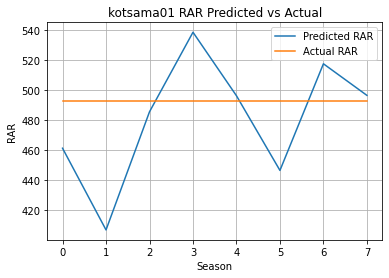

In [43]:
predict_vis(34) # Enter any index and the corresponding eligible player predicted vs actual RAR will display

In [44]:
#####This will give you a warning but it can be ignored for our purposes#####

#Adding Predicted RAR to the predictions dataframe as "P_RAR"
predictions["P_RAR"] = regr_L.predict(predictions.drop(['playerID', 'teamID', 'lgID','career_RAR'], axis = 1).astype('float64'))
#Calculating the difference between predictions and actual
predictions["Proj_Diff"] = predictions["P_RAR"]-predictions["career_RAR"]

C:\Users\timbr\AppData\Local\Temp\ipykernel_16356\3313372263.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions["P_RAR"] = regr_L.predict(predictions.drop(['playerID', 'teamID', 'lgID','career_RAR'], axis = 1).astype('float64'))
C:\Users\timbr\AppData\Local\Temp\ipykernel_16356\3313372263.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions["Proj_Diff"] = predictions["P_RAR"]-predictions["career_RAR"]


##  Top 10 Over Performers

In [45]:
predictions.nsmallest(n=10, columns=['Proj_Diff'])

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,G_dh,AGS,dRAA,RAR,lgID_AL,lgID_NL,career_RAR,PR,P_RAR,Proj_Diff
3774,cabremi01,2003,1,FLO,NL,87,314,39,84,21,...,-0.000000,89.0,-2.018352,43.983930,0,1,932.437064,1,569.635324,-362.801739
5808,cabremi01,2008,1,DET,AL,160,616,85,180,36,...,-0.585276,163.0,-9.237607,82.106511,1,0,932.437064,1,578.541138,-353.895926
1529,rodrial01,1997,1,SEA,AL,141,587,100,176,40,...,-0.100000,141.0,6.433333,83.892341,1,0,1008.924921,1,665.153390,-343.771531
6238,cabremi01,2009,1,DET,AL,160,611,96,198,34,...,-0.600000,159.0,-10.290000,96.548048,1,0,932.437064,1,641.547059,-290.890005
4455,rodrial01,2004,1,NYA,AL,155,601,112,172,24,...,-0.000000,157.0,2.132484,94.232664,1,0,1008.924921,1,722.909607,-286.015314
5811,canoro01,2008,1,NYA,AL,159,597,70,162,35,...,-0.000000,159.0,3.080000,61.215210,1,0,687.488375,0,423.226146,-264.262230
1401,jonesan01,1997,1,ATL,NL,153,399,60,92,18,...,-0.000000,154.0,-2.229610,42.872520,0,1,825.800212,1,574.569045,-251.231167
9760,uptonju01,2016,1,DET,AL,153,570,81,140,28,...,-0.193506,154.0,-6.688874,64.018819,1,0,733.866511,1,486.502473,-247.364039
4183,cabremi01,2004,1,FLO,NL,160,603,101,177,31,...,-0.099375,160.0,-7.473000,82.878829,0,1,932.437064,1,687.946366,-244.490698
2387,rodrial01,1999,1,SEA,AL,129,502,110,143,25,...,-0.000000,129.0,6.020000,85.784657,1,0,1008.924921,1,765.687519,-243.237402


## Top 10 Under Performers

In [46]:
predictions.nlargest(n=10, columns=['Proj_Diff'])

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,G_dh,AGS,dRAA,RAR,lgID_AL,lgID_NL,career_RAR,PR,P_RAR,Proj_Diff
6961,smoakju01,2010,1,TEX,AL,70,235,29,49,10,...,-0.000000,69.0,-4.180000,28.035092,1,0,284.075635,1,515.953795,231.878159
6206,beckhgo01,2009,1,CHA,AL,103,378,58,102,28,...,-0.000000,102.0,1.360000,57.883450,1,0,382.040448,1,612.540684,230.500236
3361,burrepa01,2002,1,PHI,NL,157,586,96,165,39,...,-0.000000,157.0,-7.186667,86.879626,0,1,446.631441,1,676.334864,229.703424
2640,hidalri01,2000,1,HOU,NL,153,558,118,175,42,...,-0.000000,198.0,-0.995842,98.960255,0,1,468.658749,1,689.163190,220.504441
7952,alvarpe01,2013,1,PIT,NL,152,558,70,130,22,...,-0.098675,151.0,1.874834,73.473979,0,1,372.090372,1,592.412772,220.322400
6290,escobyu01,2009,1,ATL,NL,141,528,89,158,26,...,-0.000000,139.0,6.440000,77.627061,0,1,382.988847,0,602.855459,219.866612
7242,kempma01,2011,1,LAN,NL,161,602,115,195,33,...,-0.198758,161.0,2.434783,110.145968,0,1,616.427708,1,834.704594,218.276886
2261,jonesch06,1999,1,ATL,NL,157,567,116,181,41,...,-0.000000,157.0,2.126667,114.045408,0,1,653.166231,1,870.880874,217.714644
3901,huffau01,2003,1,TBA,AL,162,636,91,198,47,...,-3.240000,165.0,-9.176727,89.406366,1,0,432.924520,1,638.069888,205.145368
7310,morrilo01,2011,1,FLO,NL,123,462,54,114,25,...,-0.098347,121.0,-5.622176,55.024632,0,1,358.984124,1,562.173651,203.189527


Players we have seen play at elite levels have repeatedly overperformed their projections, and their counterparts, the opposite. From a quick cursory glance, it seems that the projections may need to weigh past performance more as single seasons heavily influence the projections, leading to large disparities from one-off season performances. Though commonalities between top performers would certainly be an interesting and worthwhile pursuit.

## Systemic Model Weaknesses

No model is without fault. There will always be factors that cannot easily be accounted for, yet analysis must continue forth. <br>
In this project, notable weaknesses include unacountable factors such as injuries, situational-play, PED/cheating, park and luck factors, and more. There are likely interesting and novel ways to attempt to include them in modelling efforts that would aid in accuracy and robustness<br>
From a data/modelling standpoint, I initially attempted to include only players who completed their age 30 season within the provided data, yet this inclusion lead to slightly inflated RMSE values accross all models evaluated. Further exploration into why is something I would like to pursue. Multiple cleaning parameters were also placed upon the training data that has the potential for bias(i.e. AB mins, base-running exclusion, etc...).

###############################################################################################################################

## Just For Fun, Lets Try a Neural Network

 Even though Neural Networks are not the best for interpretability for player prediction, I wanted to see how a simple and small model may turn out.

In [35]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error
from numpy.random import seed
seed(1)

y = normalized_starts.career_RAR
X = normalized_starts[['yearID', 'H', 'Age','RAR']]
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [36]:
model = Sequential()
model.add(Dense(units=4, activation='relu', input_dim=4))
model.add(Dense(units=8, activation='relu'))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=8, activation='relu'))
model.add(Dense(units=4, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')

model.fit(X_train, y_train, epochs=250, batch_size=25)

Epoch 1/250
30/30 [==============================] - 0s 690us/step - loss: 249084.8750
Epoch 2/250
30/30 [==============================] - 0s 690us/step - loss: 161501.5469
Epoch 3/250
30/30 [==============================] - 0s 759us/step - loss: 50037.8789
Epoch 4/250
30/30 [==============================] - 0s 690us/step - loss: 18377.9375
Epoch 5/250
30/30 [==============================] - 0s 655us/step - loss: 17793.5176
Epoch 6/250
30/30 [==============================] - 0s 690us/step - loss: 17646.3301
Epoch 7/250
30/30 [==============================] - 0s 690us/step - loss: 17585.9414
Epoch 8/250
30/30 [==============================] - 0s 655us/step - loss: 17581.0547
Epoch 9/250
30/30 [==============================] - 0s 690us/step - loss: 17546.4473
Epoch 10/250
30/30 [==============================] - 0s 690us/step - loss: 17549.6230
Epoch 11/250
30/30 [==============================] - 0s 655us/step - loss: 17561.6523
Epoch 12/250
30/30 [==============================

In [37]:
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred, squared=False))
rmse

10/10 [==============================] - 0s 554us/step


9.930344330637945

In [47]:
predictions["NN_Predicted"] = model.predict(predictions[['yearID', 'H', 'Age','RAR']])

29/29 [==============================] - 0s 536us/step


C:\Users\timbr\AppData\Local\Temp\ipykernel_16356\660766468.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions["NN_Predicted"] = model.predict(predictions[['yearID', 'H', 'Age','RAR']])


Text(0.5, 1.0, 'vidrojo01 RAR Predicted: Basic Regression Vs. Neural Net')

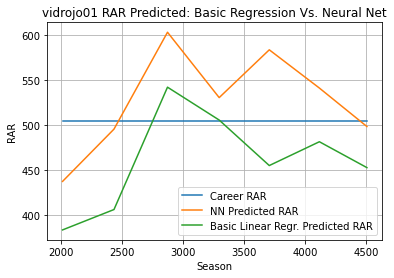

In [59]:
player_key = 29

plt.plot(predictions[predictions.playerID == players[player_key]].career_RAR, label = "Career RAR")
plt.plot(predictions[predictions.playerID == players[player_key]].NN_Predicted, label = "NN Predicted RAR")
plt.plot(predictions[predictions.playerID == players[player_key]].P_RAR, label = "Basic Linear Regr. Predicted RAR")
plt.legend()
plt.xlabel("Season")
plt.ylabel("RAR")
plt.grid()
plt.title(players[player_key]+ " RAR Predicted: Basic Regression Vs. Neural Net")

Playing around with our model results, we can see that the Neural Network model mostly mirrors the predictions of our Basic Linear Regression model. This further adds to the srgument that more complicated modelling methods may not always add value and may instead reduce the interpretability of your findings. Regardless, Deep Learning methods are sure to be useful once larger compute power and data sets are widely available. The current training system is limited by my personal computing and time restraints that an enterprise or front office would not be subject to.